In [1]:
import pandas as pd
import numpy as np

In [5]:
index50 = pd.read_csv('台灣50指數資料.csv', encoding='utf-16', sep='\t')

In [6]:
#計算市值與權重並新增欄位
index50['市值'] = index50['公眾流通係數'] * index50['前日調整收盤價']*index50['股數']
index50

,證券代碼,年月日,成份股,指數因子,公眾流通係數,股數,前日調整收盤價,前日市值比重,市值
0,TWN50 台灣50指數,20190102,1101 台泥,0.0021,0.8700,5108059911,35.60,1.0261,1.582068e+11
1,TWN50 台灣50指數,20190102,1102 亞泥,0.0011,0.6900,3361447198,33.95,0.5107,7.874358e+10
2,TWN50 台灣50指數,20190102,1216 統一,0.0023,0.8500,5682015421,69.80,2.1865,3.371140e+11
3,TWN50 台灣50指數,20190102,1301 台塑,0.0023,0.7700,6365740781,101.00,3.2110,4.950637e+11
4,TWN50 台灣50指數,20190102,1303 南亞,0.0027,0.7200,7930821589,75.50,2.7962,4.311195e+11
...,...,...,...,...,...,...,...,...,...
48896,TWN50 台灣50指數,20221230,5880 合庫金,0.0044,0.7200,14008935446,25.65,1.0845,2.587170e+11
48897,TWN50 台灣50指數,20221230,6415 矽力*-KY,0.0001,0.6600,381075821,432.50,0.4560,1.087781e+11
48898,TWN50 台灣50指數,20221230,6505 台塑化,0.0006,0.1500,9525959652,79.70,0.4774,1.138828e+11
48899,TWN50 台灣50指數,20221230,8046 南電,0.0001,0.3249,646165487,231.00,0.2033,4.849595e+10


In [16]:
index50_daily_return = pd.read_csv('台灣50指數日報酬.csv', encoding='utf-16', sep='\t')
index50_daily_return

,證券代碼,年月日,日報酬率 %
0,TWN50 台灣50指數,20190102,-2.2291
1,TWN50 台灣50指數,20190103,-0.8722
2,TWN50 台灣50指數,20190104,-1.7146
3,TWN50 台灣50指數,20190107,2.3669
4,TWN50 台灣50指數,20190108,-0.3575
...,...,...,...
972,TWN50 台灣50指數,20221226,0.1760
973,TWN50 台灣50指數,20221227,0.2387
974,TWN50 台灣50指數,20221228,-1.1119
975,TWN50 台灣50指數,20221229,-0.8652


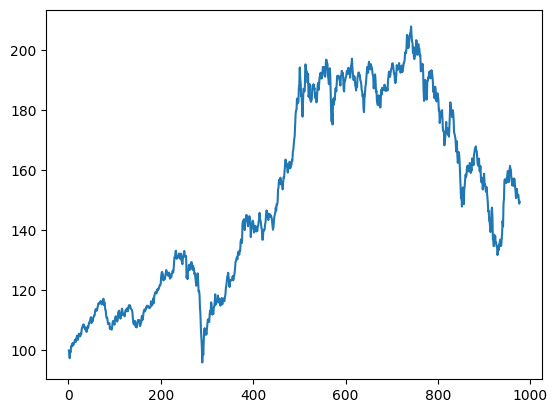

In [20]:
#畫出台50指成長曲線
import matplotlib.pyplot as plt

assets = []
for i in range(len(index50_daily_return)):
    if i == 0:
        assets.append(100)
    else:
        assets.append(assets[i-1]*(1+index50_daily_return['日報酬率 %'][i]/100))

plt.plot([day for day in range(1, len(index50_daily_return)+1)], assets)


In [22]:
#將dataframe依照年月日切割，存入dict, ex. data_dict['2019/01/02']可取出當天的資料
data_of_the_day = {}
for i in range(0, len(index50)):
    if index50['年月日'][i] not in data_of_the_day:
        data_of_the_day[index50['年月日'][i]] = index50.iloc[i:i+1]
    else:
        data_of_the_day[index50['年月日'][i]] = pd.concat([data_of_the_day[index50['年月日'][i]], index50.iloc[i:i+1]])

In [30]:
#算權重
def get_weight(daily_data):
    weight = daily_data['市值'] / daily_data['市值'].sum()
    return weight

# # 使用範例
# get_weight(data_dict[20190102])

In [28]:
import datetime

def find_first_friday(year):
    # 設日期為每個月的第一天
    first_friday = []
    for month in range(1, 13):
        date = datetime.date(year, month, 1)
        while date.weekday() != 4:  # 星期五對應的數字為4
            date = date + datetime.timedelta(days=1)
        first_friday.append(date)
    return first_friday

# # 使用範例
# year = 2022

# find_first_friday(year)
